<a href="https://colab.research.google.com/github/zbiswas3/Datascience-Projects/blob/master/Capstone%20Project%202%20-%20MS%20Coco%20Image%20Captioning/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
%matplotlib inline
from __future__ import print_function
from pycocotools.coco import COCO
import os, sys, zipfile
import urllib.request
import shutil
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [0]:
# Record package versions for reproducibility
# print("os: %s" % os.name)
# print("sys: %s" % sys.version)
# print("numpy: %s, %s" % (np.__version__, np.__file__))

## Load Data

In [0]:
# Setup data paths
dataDir = '../..'
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)
# print (annDir)
# print (annFile)
# print (annZipFile)
# print (annURL)

In [4]:
# Download data if not available locally
if not os.path.exists(annDir):
    os.makedirs(annDir)
if not os.path.exists(annFile):
    if not os.path.exists(annZipFile):
        print ("Downloading zipped annotations to " + annZipFile + " ...")
        with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print ("... done downloading.")
    print ("Unzipping " + annZipFile)
    with zipfile.ZipFile(annZipFile,"r") as zip_ref:
        zip_ref.extractall(dataDir)
    print ("... done unzipping")
print ("Will use annotations in " + annFile)

... done downloading.
Unzipping ../../annotations_trainval2017.zip
... done unzipping
Will use annotations in ../../annotations/instances_val2017.json


In [5]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [6]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
electronic accessory appliance furniture indoor outdoor sports animal food kitchen person vehicle


## Data Samples

In [0]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [549220])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [0]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
# plt.axis('off')
# plt.imshow(I)
# plt.show()

In [0]:
# load and display instance annotations
# plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
# coco.showAnns(anns)

In [10]:
# initialize COCO api for person keypoints annotations
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [0]:
# load and display keypoints annotations
# plt.imshow(I); plt.axis('off')
# ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
# coco_kps.showAnns(anns)

In [12]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [13]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
# plt.imshow(I); plt.axis('off'); plt.show()

A dog on a leash trying to ride a skateboard.
A small dog standing on top of a skateboard.
A very cute dog standing on a skate board.
a dog that is sitting on a skate board
a close up of a dog riding a skate board 


In [14]:
print("Dataset Containsts {} images.".format(len(coco.imgs.keys())))

Dataset Containsts 5000 images.


In [15]:
print("Training data has {} Categories.".format(len(coco.cats.keys())))

Training data has 80 Categories.


## Form Dataframes from the Training Data

In [16]:
# all the images and corresponding sources
img_data = pd.DataFrame(coco.dataset['images']).rename(index=str, columns={'id':'image_id'})
img_data.head(3)

,coco_url,date_captured,file_name,flickr_url,height,image_id,license,width
0,http://images.cocodataset.org/val2017/00000039...,2013-11-14 17:02:52,000000397133.jpg,http://farm7.staticflickr.com/6116/6255196340_...,427,397133,4,640
1,http://images.cocodataset.org/val2017/00000003...,2013-11-14 20:55:31,000000037777.jpg,http://farm9.staticflickr.com/8429/7839199426_...,230,37777,1,352
2,http://images.cocodataset.org/val2017/00000025...,2013-11-14 22:32:02,000000252219.jpg,http://farm4.staticflickr.com/3446/3232237447_...,428,252219,4,640


In [17]:
segmentation_data = pd.DataFrame(coco.dataset['annotations'])
segmentation_data.head(3)

,area,bbox,category_id,id,image_id,iscrowd,segmentation
0,702.10575,"[473.07, 395.93, 38.65, 28.67]",18,1768,289343,0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416...."
1,27718.47630,"[272.1, 200.23, 151.97, 279.77]",18,1773,61471,0,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427...."
2,78969.31690,"[124.71, 196.18, 372.85, 356.81]",18,2551,472375,0,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347...."


In [18]:
captions = pd.DataFrame(coco_caps.dataset['annotations']).rename(index=str, columns={'id':'caption_id'})
captions.head(3)

,caption,caption_id,image_id
0,A black Honda motorcycle parked in front of a ...,38,179765
1,A Honda motorcycle parked in a grass driveway,182,179765
2,An office cubicle with four different types of...,401,190236


In [19]:
captions[captions.image_id == 289343]

,caption,caption_id,image_id
2137,A man is riding a large bike through the park.,432953,289343
2140,A person riding a very tall bike in the street.,433580,289343
2162,A man this is on a high wheel bicycle.,438647,289343
2164,A person riding a bicycle on a deserted street.,438851,289343
2169,A person rides a bike on the road.,439640,289343


In [20]:
print("{} total images are available.".format(len(set(img_data.image_id))))
print("{} images have segmentations info available.".format(len(set(segmentation_data.image_id))))
print("{} images have captions available.".format(len(set(captions.image_id))))

5000 total images are available.
4952 images have segmentations info available.
5000 images have captions available.


In [21]:
train_data = pd.merge(img_data, captions, how='inner', on = ['image_id'] )
train_data.head(3)

,coco_url,date_captured,file_name,flickr_url,height,image_id,license,width,caption,caption_id
0,http://images.cocodataset.org/val2017/00000039...,2013-11-14 17:02:52,000000397133.jpg,http://farm7.staticflickr.com/6116/6255196340_...,427,397133,4,640,A man is in a kitchen making pizzas.,370509
1,http://images.cocodataset.org/val2017/00000039...,2013-11-14 17:02:52,000000397133.jpg,http://farm7.staticflickr.com/6116/6255196340_...,427,397133,4,640,Man in apron standing on front of oven with pa...,370584
2,http://images.cocodataset.org/val2017/00000039...,2013-11-14 17:02:52,000000397133.jpg,http://farm7.staticflickr.com/6116/6255196340_...,427,397133,4,640,A baker is working in the kitchen rolling dough.,372252


In [22]:
# all the categories and subcategories
category_data = pd.DataFrame(cats).rename(index=str, columns={'id':'category_id','name':'category'})
print("There are {} unique categories: ".format(len(set(category_data.category))))
category_data.head(3)

There are 80 unique categories: 


,category_id,category,supercategory
0,1,person,person
1,2,bicycle,vehicle
2,3,car,vehicle


In [23]:
train_df = train_data.drop_duplicates(subset='image_id')
train_df.shape

(5000, 10)

In [24]:
train_df.caption = 'startings '+ train_df.caption + ' endings'

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Build an Image Encoder (VGG16)

In [25]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential, load_model, Model
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications import VGG16
from keras.preprocessing import image, text
from PIL import Image
image_model = VGG16(weights='imagenet', include_top=True)


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


553467904/553467096 [==============================] - 16s 0us/step


In [0]:
temp_loc = urllib.request.urlretrieve(train_data.coco_url[10], train_data.file_name[10])


In [0]:
sample_img = image.load_img(train_data.file_name[10], target_size=(224, 224))
sample_img = image.img_to_array(sample_img)
sample_img = sample_img.reshape((1, sample_img.shape[0], sample_img.shape[1], sample_img.shape[2]))

In [0]:
 sample_image = preprocess_input(sample_img)

In [0]:
image_size = (224, 224)
transfer_values_size = 4096

In [0]:
transfer_layer = image_model.get_layer('fc1')

In [31]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
image_model_transfer = Model(inputs=image_model.input, outputs=transfer_layer.output)

In [0]:
def image_preprocessor(url, image_size, file_name):
  urllib.request.urlretrieve(url, file_name)
  sample_img = image.load_img(file_name, target_size=image_size)
  sample_img_arr = image.img_to_array(sample_img)
  sample_img_arr = sample_img_arr.reshape((1, sample_img_arr.shape[0], sample_img_arr.shape[1], sample_img_arr.shape[2]))
  input_img = preprocess_input(sample_img_arr)
  return image_model_transfer.predict(input_img)

In [34]:
%%time
transfer_values = []
for i in range(train_df.shape[0]):
  transfer_values.append(image_preprocessor(train_df.coco_url.iloc[i], image_size, train_df.file_name.iloc[i]))
  

CPU times: user 1min 33s, sys: 38.4 s, total: 2min 12s
Wall time: 45min 58s


### Generate Text Data




In [0]:
# vocab = " ".join(train_df['caption']).lower()
# words = list(set(vocab.split()))
# id_to_word = {}
# word_to_id = {}
# id = 1
# for word in list(words):
#   word_to_id[word] = id
#   id_to_word[id] = word
#   id += 1


In [35]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_df.caption.values)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(train_df.caption.values)
print(dtexts[:5])

vocabulary size : 3428
[[2, 1, 12, 11, 7, 1, 70, 430, 643, 3], [2, 6, 346, 26, 38, 6, 70, 63, 1, 144, 4, 210, 5, 34, 3], [2, 1, 30, 8, 1, 788, 411, 5, 1, 76, 24, 3], [2, 1, 30, 5, 1, 90, 9, 238, 20, 1, 362, 145, 3], [2, 1, 61, 238, 68, 5, 1, 43, 374, 3]]


In [36]:
maxlen = np.max([len(text) for text in dtexts])
print('Size of the longest caption:',maxlen)

Size of the longest caption: 30


## Split Train and Validation Data

In [0]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(transfer_values,Ntest,Nval)

In [38]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 
            
            Xtext.append(in_text)
            Ximage.append(image.flatten())
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage, )
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)


# captions/images = 3000
 (34221, 30) (34221, 4096) (34221, 3428)
# captions/images = 1000
 (11294, 30) (11294, 4096) (11294, 3428)


### Building LSTM Model

In [0]:
from keras.layers import Input, LSTM, Dropout, TimeDistributed, Dense, Flatten, Dropout, Activation, Embedding

In [40]:
from keras import layers


## image feature
dim_embedding = 64  

input_image = Input(shape=(transfer_values_size,))
fimage = Dense(256,activation='relu',name="ImageFeature")(input_image)

## sequence model
input_txt = Input(shape=(maxlen,))
ftxt = Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
se1 = Dropout(0.2)(ftxt)
ftxt = LSTM(256,name="CaptionFeature2" )(se1)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = Dense(256,activation='relu')(decoder)
output = Dense(vocab_size,activation='softmax')(decoder)
cap_model = Model(inputs=[input_image, input_txt],outputs=output)

cap_model.compile(loss='categorical_crossentropy', optimizer='adam') # try adam 

print(cap_model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       219392      input_3[0][0]                    
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 30, 256)      328704      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30, 256)      0           CaptionFeature[0][0]        

In [41]:
#Train The model
%%time
from keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
hist = cap_model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=30, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 34221 samples, validate on 11294 samples
Epoch 1/30
 - 222s - loss: 5.2196 - val_loss: 4.7838
Epoch 2/30
 - 220s - loss: 4.2911 - val_loss: 4.4542
Epoch 3/30
 - 218s - loss: 3.7805 - val_loss: 4.2243
Epoch 4/30
 - 217s - loss: 3.4607 - val_loss: 4.1639
Epoch 5/30
 - 219s - loss: 3.2420 - val_loss: 4.1593
Epoch 6/30
 - 219s - loss: 3.0682 - val_loss: 4.1578
Epoch 7/30
 - 221s - loss: 2.9066 - val_loss: 4.2288
Epoch 8/30
 - 218s - loss: 2.7769 - val_loss: 4.2567
Epoch 9/30
 - 219s - loss: 2.6527 - val_loss: 4.3453
Epoch 10/30
 - 218s - loss: 2.5373 - val_loss: 4.3947
Epoch 11/30
 - 219s - loss: 2.4248 - val_loss: 4.4873
Epoch 12/30
 - 218s - loss: 2.3183 - val_loss: 4.5496
Epoch 13/30
 - 217s - loss: 2.2185 - val_loss: 4.6794
Epoch 14/30
 - 217s - loss: 2.1249 - val_loss: 4.7128
Epoch 15/30
 - 218s - loss: 2.0343 - val_loss: 4.7956
Epoch 16/30
 - 219s - loss: 1.9510 - val_loss: 4.8645
Epoch 17/30
 - 219s - loss: 1.8603 - val_loss: 

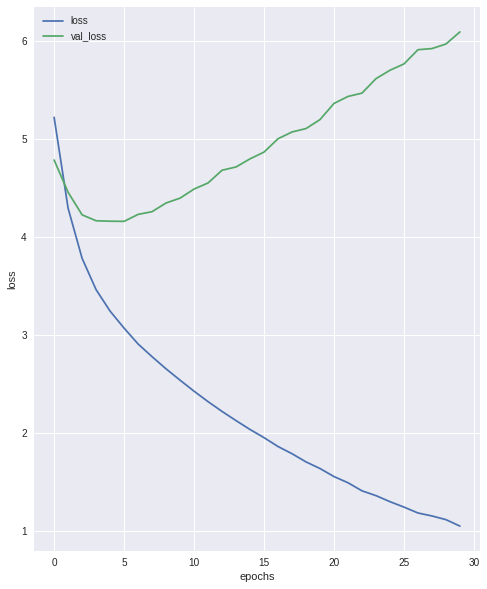

In [42]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
#fnames are the names of the image files        
fnames = train_df.file_name.values
#dcaptions are the captions of the images 
dcaptions = train_df.caption.values

In [0]:
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

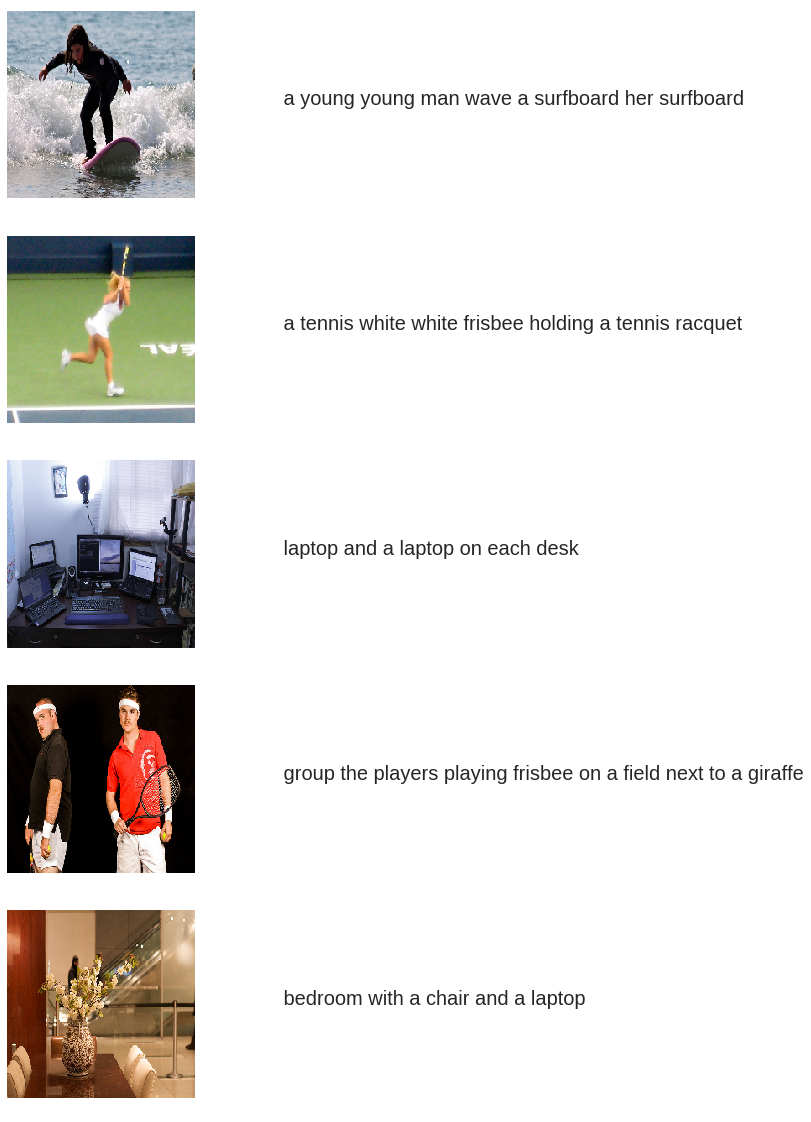

CPU times: user 6.84 s, sys: 892 ms, total: 7.73 s
Wall time: 4.69 s


In [45]:
%%time
from keras.preprocessing.image import load_img, img_to_array
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4096)
    '''

    in_text = ''

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = cap_model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]        
        if newword == "endings":
            break
        in_text += " " + newword

    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_train[8:13],di_train[8:13]):
    ## images 
    filename = jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature)
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

## Evaluating The Model Performance

In [46]:
%%time
from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature)
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  20.00% is done..
  40.00% is done..
  60.00% is done..
  80.00% is done..
  100.00% is done..
CPU times: user 19min 56s, sys: 1min 49s, total: 21min 46s
Wall time: 12min 2s


In [47]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.347
